In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import nemo
import nemo.collections.asr as nemo_asr 
import numpy as np

import scipy.io.wavfile as wave

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
/workspace/NeMo/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')


In [2]:
MODEL_YAML = './examples/asr/configs/jasper10x5dr.yaml'
CHECKPOINT_ENCODER = '/raid/data/NeMo-CHECKPOINTS/master/multidataset_v2_jasper10x5dr/JasperEncoder-STEP-400000.pt'
CHECKPOINT_DECODER = '/raid/data/NeMo-CHECKPOINTS/master/multidataset_v2_jasper10x5dr/JasperDecoderForCTC-STEP-400000.pt'

In [3]:
from ruamel.yaml import YAML
yaml = YAML(typ="safe")
with open(MODEL_YAML) as f:
    model_definition = yaml.load(f)
labels = model_definition['labels']
model_definition['AudioToMelSpectrogramPreprocessor']['dither'] = 0

In [4]:
model_definition['AudioToMelSpectrogramPreprocessor']

{'window_size': 0.02,
 'window_stride': 0.01,
 'window': 'hann',
 'normalize': 'per_feature',
 'n_fft': 512,
 'features': 64,
 'dither': 0,
 'pad_to': 16,
 'stft_conv': True}

In [5]:
neural_factory = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
    backend=nemo.core.Backend.PyTorch)

[NeMo W 2020-05-02 09:01:00 deprecated:68] Function ``_get_trainer`` is deprecated. It is going to be removed in the future version.


In [6]:
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(
    **model_definition["AudioToMelSpectrogramPreprocessor"])

jasper_encoder = nemo_asr.JasperEncoder(
    feat_in=model_definition["AudioToMelSpectrogramPreprocessor"]["features"],
    **model_definition["JasperEncoder"])

jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=model_definition["JasperEncoder"]["jasper"][-1]["filters"],
    num_classes=len(labels))

greedy_decoder = nemo_asr.GreedyCTCDecoder()

[NeMo I 2020-05-02 09:01:00 features:144] PADDING: 16
[NeMo I 2020-05-02 09:01:00 features:152] STFT using conv


In [7]:
jasper_encoder.restore_from(CHECKPOINT_ENCODER)
jasper_decoder.restore_from(CHECKPOINT_DECODER)

In [8]:
sample_rate, signal = wave.read('/raid/data/librispeech/LibriSpeech/dev-clean-wav/1272-128104-0000.wav')

# make sure that sample rate is the same as expected by Jasper
assert sample_rate == model_definition['sample_rate']

In [9]:
from nemo.backends.pytorch.nm import DataLayerNM
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch

class AudioDataLayer(DataLayerNM):
    @property
    def output_ports(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = np.reshape(signal.astype(np.float32)/32768., [1, -1])
        #self.signal = np.reshape(signal.astype(np.float32)/np.max(np.abs(signal)), [1, -1])
        
        self.signal_shape = np.expand_dims(self.signal.size, 0).astype(np.int64)
        self.output = True

    def __len__(self):
        return 1

    @property
    def dataset(self):
        return None

    @property
    def data_iterator(self):
        return self

In [10]:
# Instantiate necessary neural modules
data_layer = AudioDataLayer(sample_rate=model_definition['sample_rate'])

# Define inference DAG
audio_signal, audio_signal_len = data_layer()
processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)
encoded, encoded_len = jasper_encoder(audio_signal=processed_signal,
                                      length=processed_signal_len)
log_probs = jasper_decoder(encoder_output=encoded)
predictions = greedy_decoder(log_probs=log_probs)

In [11]:
data_layer.set_signal(signal)
tensors = neural_factory.infer([
    audio_signal,
    processed_signal,
    encoded,
    log_probs,
    predictions,
])
audio = tensors[0][0][0].cpu().numpy()
features = tensors[1][0][0].cpu().numpy()
encoded_features = tensors[2][0][0].cpu().numpy(),
probs = tensors[3][0][0].cpu().numpy()
preds = tensors[4][0]

[NeMo I 2020-05-02 09:01:08 actions:729] Evaluating batch 0 out of 1


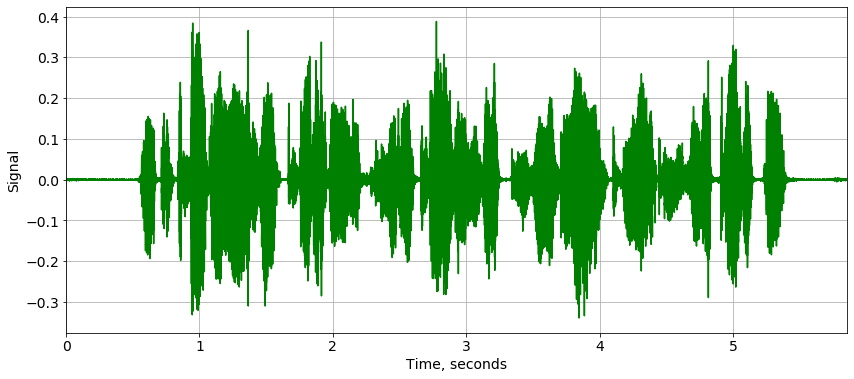

In [12]:
plt.figure(figsize=[14,6])
plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})
plt.plot(np.arange(audio.size)/sample_rate, audio, 'g')
plt.xlim([0, audio.size/sample_rate])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

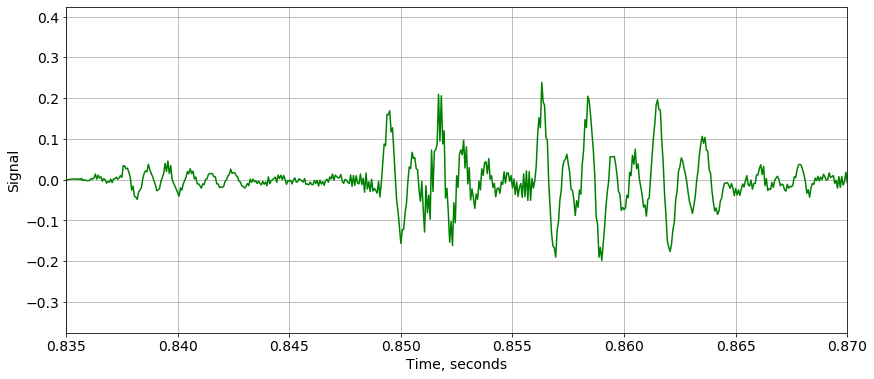

In [13]:
plt.figure(figsize=[14,6])
plt.plot(np.arange(audio.size)/sample_rate, audio, 'g')
plt.xlim([0.835, 0.87])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

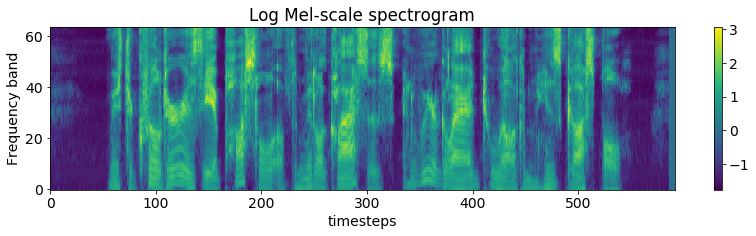

In [14]:
plt.figure(figsize=[14,3])
plt.imshow(features)
plt.axis('tight')
plt.ylabel('Frequency band')
plt.xlabel('timesteps')
plt.colorbar()
plt.title('Log Mel-scale spectrogram')
plt.gca().invert_yaxis()

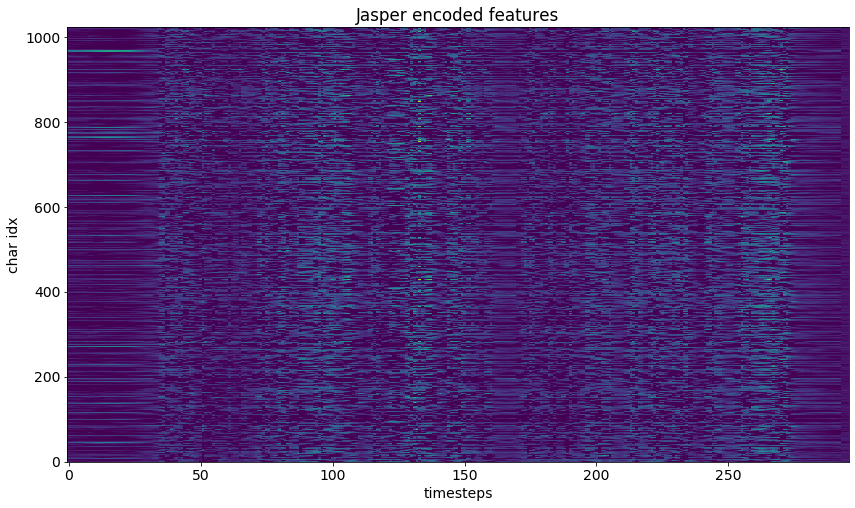

In [15]:
plt.figure(figsize=[14,8])
plt.imshow(encoded_features[0])
plt.axis('tight')
plt.ylabel('char idx')
plt.xlabel('timesteps')
plt.title('Jasper encoded features')
plt.gca().invert_yaxis()

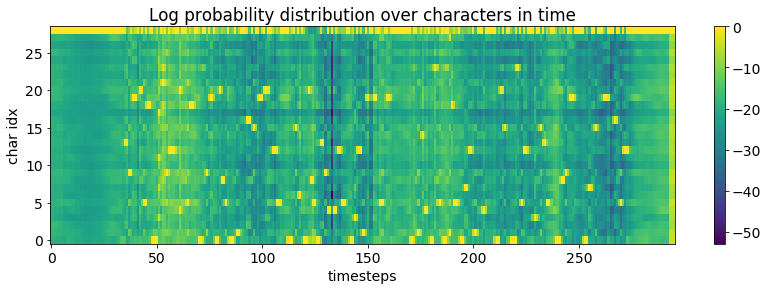

In [16]:
plt.figure(figsize=[14,4])
plt.imshow(probs.transpose())
plt.axis('tight')
plt.ylabel('char idx')
plt.xlabel('timesteps')
plt.colorbar()
plt.title('Log probability distribution over characters in time')
plt.gca().invert_yaxis()

In [17]:
from nemo.collections.asr.helpers import post_process_predictions
post_process_predictions([preds], labels)

['mister quilter is the apostle of the middle classes and we are glad to welcome his gospel']